In [12]:
#!conda install pytorch
#!conda install Pillow
#!conda install scikit-image
#conda install -c conda-forge opencv
#conda install -c conda-forge keras
#conda install -c conda-forge tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Setting up GPU for caluculations

In [4]:
#conda create --name tf_gpu tensorflow-gpu 

^C

Note: you may need to restart the kernel to use updated packages.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
pysical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(pysical_devices))
tf.config.experimental.set_memory_growth(pysical_devices[0], True)

Num GPUs Available:  1


## InceptionV3 model

Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Found 602 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

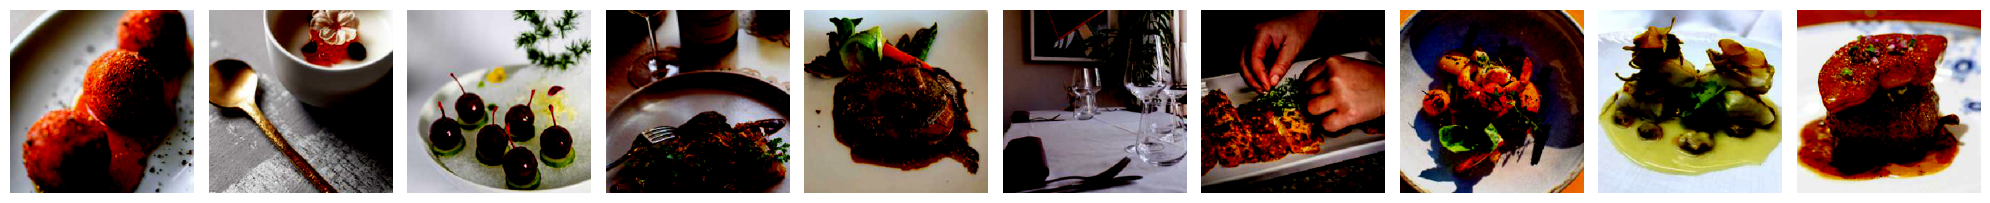

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [2]:
#Set up values
epochs = 30
input_shape=(299,299,3)
batch_size=16
classes=['On_a_budget', 'Moderate_spend', 'Special_occasion', 'Spare_no_expense']
l1_reg = 0.001
l2_reg = 0.001

train_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2'
test_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test_2'
valid_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\valid_2'

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input, 
                                   #rotation_range=30, 
                                   #width_shift_range=0.2, 
                                   #height_shift_range=0.2, 
                                   #shear_range=0.2, 
                                   #zoom_range=0.2, 
                                   #horizontal_flip=True, 
                                   #fill_mode='nearest'
                                   )
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input, 
                                  #rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
                                   )

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training',
classes=classes,
shuffle=True)

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training',
classes=classes,
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(299, 299),
batch_size=batch_size,
color_mode='rgb',
class_mode='categorical',
classes=classes)


imgs, labels = next(train_batch)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [5]:
import tensorflow_addons as tfa
from tensorflow.keras.applications import InceptionV3

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)

# Setting class weights
class_indices = train_batch.class_indices
num_classes = len(class_indices)
total_samples = train_batch.samples

class_samples = [train_batch.classes.tolist().count(i) for i in range(num_classes)]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_batch.classes), y=train_batch.classes)
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}

# Giving the model a name and setting up TensorBoard
dense_layers = 5
conv_layers = 15
layer_sizes_conv = 512
layer_sizes_dense = 1024
NAME= f"InceptionV3- {conv_layers}-conv-{layer_sizes_conv}-nodes-{dense_layers}-dense-{layer_sizes_dense}-neuros-4BatchNormInMaxpool-trainLayers(-5000)-learingRate-0.0001-RegularizersL1-L2-dropout-0.2-10epochs"
log_dir = f"logs/fit_8/{NAME}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the earlier layers of InceptionV3
for layer in base_model.layers[:-5000]:
    layer.trainable = False

# Fine-tune the last two blocks of InceptionV3
for layer in base_model.layers[-5000:]:
    layer.trainable = True

# Create the model
model = Sequential()
model.add(base_model)

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_1'))
model.add(Activation('relu', name='act_1'))
model.add(BatchNormalization(name='bn_1'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_2'))
model.add(Activation('relu', name='act_2'))
model.add(BatchNormalization(name='bn_2'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_3'))
model.add(Activation('relu', name='act_3'))
model.add(BatchNormalization(name='bn_3'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_4'))
model.add(Activation('relu', name='act_4'))
model.add(BatchNormalization(name='bn_4'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_5'))
model.add(Activation('relu', name='act_5'))
model.add(BatchNormalization(name='bn_5'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_6'))
model.add(Activation('relu', name='act_6'))
model.add(BatchNormalization(name='bn_6'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_7'))
model.add(Activation('relu', name='act_7'))
model.add(BatchNormalization(name='bn_7'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_8'))
model.add(Activation('relu', name='act_8'))
model.add(BatchNormalization(name='bn_8'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_9'))
model.add(Activation('relu', name='act_9'))
model.add(BatchNormalization(name='bn_9'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_10'))
model.add(Activation('relu', name='act_10'))
model.add(BatchNormalization(name='bn_10'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_11'))
model.add(Activation('relu', name='act_11'))
model.add(BatchNormalization(name='bn_11'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_12'))
model.add(Activation('relu', name='act_12'))
model.add(BatchNormalization(name='bn_12'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_13'))
model.add(Activation('relu', name='act_13'))
model.add(BatchNormalization(name='bn_13'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_14'))
model.add(Activation('relu', name='act_14'))
model.add(BatchNormalization(name='bn_14'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_15'))
model.add(Activation('relu', name='act_15'))
model.add(BatchNormalization(name='bn_15'))



model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))

model.add(Dense(4))
model.add(Activation('softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), 
                       tfa.metrics.F1Score(num_classes, average="macro")])


Model= model.fit(train_batch, epochs=epochs, validation_data=test_batch, class_weight=class_weight_dict, 
          callbacks=[reduce_lr, tensorboard_callback], steps_per_epoch=len(train_batch), validation_steps=len(test_batch))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/30
1108/1108 [==============================] - 198s 165ms/step - loss: 26.2988 - accuracy: 0.3330 - precision: 0.4627 - f1_score: 0.2827 - val_loss: 1.5483 - val_accuracy: 0.3318 - val_precision: 0.3607 - val_f1_score: 0.2214
Epoch 2/30
1108/1108 [==============================] - 174s 157ms/step - loss: 1.4264 - accuracy: 0.3466 - precision: 0.4695 - f1_score: 0.2787 - val_loss: 1.4761 - val_accuracy: 0.3127 - val_precision: 0.2694 - val_f1_score: 0.2081
Epoch 3/30
1108/1108 [==============================] - 175s 157ms/step - loss: 1.4027 - accuracy: 0.3512 - precision: 0.4490 - f1_score: 0.2886 - val_loss: 1.5532 - val_accuracy: 0.3389 - val_precision: 0.3317 - val_f1_score: 0.2426
Epoch 4/30
1108/1108 [==============================] - 175s 157ms/step - loss: 1.3770 - accuracy: 0.3596 - precision: 0.4936 - f1_score: 0.3006 - val_loss: 1.4508 - val_accuracy: 0.3216 - val_precision: 0.3300 - val_f1_score: 0.2267
Epoch 5/30
1108/1108 [==============================] - 175s 15

ValueError: too many values to unpack (expected 2)

tensorboard --logdir=C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\logs\fit
- this one contains very basic model with no difference in filters for convelutional and desnse layers, also very minimal image proseccing.    


tensorboard --logdir=C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\logs\fit_2
- This ine has difference in the filters in dense and convelutional layers and all the image processing
- After error it failed complitely after running for 500min 

tensorboard --logdir=C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\logs\fit_3
- With error handeling 

tensorboard --logdir=C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\logs\fit_4
- Adding difference in gense and conv layer  

tensorboard --logdir=C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\logs\fit_5
- Reduced amount of nearons in dense layer as this was to much for the pc (validtaion is about 30%)
(With max pooling after convelutional layers)

tensorboard --logdir=C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\logs\fit_6
- delete Maxpooling and add a BatchNormalization and GlobalAvg after all the convelutional layers 
- After running for 24h -> higher number of conv layers and dense layers performs better

tensorboard --logdir=C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\logs\fit_7
- Same model as fit_6 but higher number of layers and more neurons + higher batch size (32)
- +- 38% accuracy in train 34 accuracy in test 

Forgot the include the trained model so fit 7 is bad

## ResNet

Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Found 602 images belonging to 4 classes.


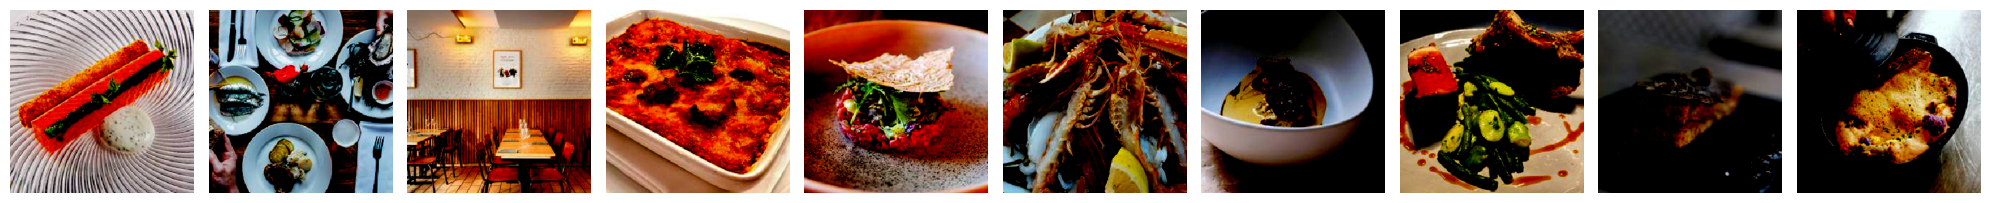

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [26]:
#Set up values
epochs = 20
input_shape=(299,299,3)
batch_size=10
classes=['On_a_budget', 'Moderate_spend', 'Special_occasion', 'Spare_no_expense']

train_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2'
test_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test_2'
valid_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\valid_2'

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input, 
                                   #rotation_range=30, 
                                   #width_shift_range=0.2, 
                                   #height_shift_range=0.2, 
                                   #shear_range=0.2, 
                                   #zoom_range=0.2, 
                                   #horizontal_flip=True, 
                                   #fill_mode='nearest'
                                   )
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input, 
                                  #rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
                                   )

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training',
classes=classes,
shuffle=True)

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training',
classes=classes,
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(299, 299),
batch_size=batch_size,
color_mode='rgb',
class_mode='categorical',
classes=classes)


imgs, labels = next(train_batch)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [27]:
# Import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2


# Drops learning rate by half if the accuracy does not improve after 2 epochs (patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)

# Setting class weights
class_indices = train_batch.class_indices
num_classes = len(class_indices)
total_samples = train_batch.samples

class_samples = [train_batch.classes.tolist().count(i) for i in range(num_classes)]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_batch.classes), y=train_batch.classes)
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}

# Giving the model a name and setting up TensorBoard
dense_layers = 5
conv_layers = 12
layer_sizes_conv = 265
layer_sizes_dense = 1024
NAME= f"ResNet- {conv_layers}-conv-{layer_sizes_conv}-nodes-{dense_layers}-dense-{layer_sizes_dense}-neurons-4BatchNormInMaxpool-trainLayers(-100)-learingRate-0.0001"
log_dir = f"logs/fit_8/{NAME}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create the base model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the earlier layers of ResNet50V2
for layer in base_model.layers[:-100]:
    layer.trainable = False

# Fine-tune the last two blocks of ResNet50V2
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Create the model
model = Sequential()
model.add(base_model)

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(4))
model.add(Activation('softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(train_batch, epochs=epochs, validation_data=test_batch, class_weight=class_weight_dict, 
          callbacks=[reduce_lr, tensorboard_callback], steps_per_epoch=len(train_batch), validation_steps=len(test_batch))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
1773/1773 [==============================] - 187s 103ms/step - loss: 1.2985 - accuracy: 0.3485 - val_loss: 1.3733 - val_accuracy: 0.3392
Epoch 2/20
1773/1773 [==============================] - 151s 85ms/step - loss: 1.2590 - accuracy: 0.3679 - val_loss: 1.3308 - val_accuracy: 0.3169
Epoch 3/20
1773/1773 [==============================] - 146s 82ms/step - loss: 1.2335 - accuracy: 0.3925 - val_loss: 1.3491 - val_accuracy: 0.3456
Epoch 4/20
1773/1773 [==============================] - 127s 72ms/step - loss: 1.2083 - accuracy: 0.4047 - val_loss: 1.3833 - val_accuracy: 0.3307
Epoch 5/20
1773/1773 [==============================] - 149s 84ms/step - loss: 1.1519 - accuracy: 0.4323 - val_loss: 1.3271 - val_accuracy: 0.3665
Epoch 6/20
1773/1773 [==============================] - 151s 85ms/step - loss: 1.0670 - accuracy: 0.4707 - val_loss: 1.9464 - val_accuracy: 0.3304
Epoch 7/20
1773/1773 [==============================] - 140s 79ms/step - loss: 0.9494 - accuracy: 0.5265 - val_loss: 

KeyboardInterrupt: 

In [35]:
epochs=10

# Setting class weights
class_indices = train_batch.class_indices
num_classes = len(class_indices)
total_samples = train_batch.samples

class_samples = [train_batch.classes.tolist().count(i) for i in range(num_classes)]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_batch.classes), y=train_batch.classes)
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}


#Giving the model a name and setting up TensorBoard
dense_layers = 5
conv_layers = 6
layer_sizes_conv = 265
layer_sizes_dense = 1024
NAME= f"{conv_layers}-conv-{layer_sizes_conv}-nodes-{dense_layers}-dense-{layer_sizes_dense}-neurons-Maxpool-4BatchNormInMaxpool-trainLayers-4outputs"
log_dir = f"logs/fit_8/{NAME}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create the shared layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers[:-17]:
    layer.trainable = False
for layer in base_model.layers[-17:]:
    layer.trainable = True

# Add the output layers
x = base_model.output
x = Conv2D(filters=265, kernel_size=(3, 3), padding='same', input_shape=input_shape)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(filters=265, kernel_size=(3, 3), padding='same', input_shape=input_shape)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(filters=265, kernel_size=(3, 3), padding='same', input_shape=input_shape)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(filters=265, kernel_size=(3, 3), padding='same', input_shape=input_shape)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(filters=265, kernel_size=(3, 3), padding='same', input_shape=input_shape)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(filters=265, kernel_size=(3, 3), padding='same', input_shape=input_shape)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Flatten()(x)

x = Dense(1024)(x)
x = Activation('relu')(x)
x = Dense(1024)(x)
x = Activation('relu')(x)
x = Dense(1024)(x)
x = Activation('relu')(x)
x = Dense(1024)(x)
x = Activation('relu')(x)
x = Dense(1024)(x)
x = Activation('relu')(x)

output1 = Dense(1, activation='sigmoid', name='On_a_budget')(x)
output2 = Dense(1, activation='sigmoid', name='Moderate_spend')(x)
output3 = Dense(1, activation='sigmoid', name='Special_occasion')(x)
output4 = Dense(1, activation='sigmoid', name='Spare_no_expense')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=[output1, output2, output3, output4])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(train_batch, epochs=epochs, validation_data=test_batch, class_weight=class_weight_dict, 
            callbacks=[tensorboard_callback], steps_per_epoch=len(train_batch), validation_steps=len(test_batch))

# Evaluate the model on the test set
results = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Epoch 1/10
1773/1773 [==============================] - 91s 48ms/step - loss: 2.2514 - On_a_budget_loss: 0.5629 - Moderate_spend_loss: 0.5629 - Special_occasion_loss: 0.5629 - Spare_no_expense_loss: 0.5628 - On_a_budget_accuracy: 0.7498 - Moderate_spend_accuracy: 0.7499 - Special_occasion_accuracy: 0.7499 - Spare_no_expense_accuracy: 0.7500 - val_loss: 2.2499 - val_On_a_budget_loss: 0.5625 - val_Moderate_spend_loss: 0.5625 - val_Special_occasion_loss: 0.5625 - val_Spare_no_expense_loss: 0.5625 - val_On_a_budget_accuracy: 0.7500 - val_Moderate_spend_accuracy: 0.7500 - val_Special_occasion_accuracy: 0.7500 - val_Spare_no_expense_accuracy: 0.7500
Epoch 2/10
1773/1773 [==============================] - 78s 44ms/step - loss: 2.2494 - On_a_budget_loss: 0.5623 - Moderate_spend_loss: 0.5623 - Special_occasion_loss: 0.5623 - Spare_no_expense_loss: 0.5623 - On_a_budget_accuracy: 0.7500 - Moderate_spend_accuracy: 0.7500 - Special_occasion_accuracy: 0.7500 - Spare_no_expense_accuracy: 0.7500 - val

ValueError: too many values to unpack (expected 2)

61/61 [==============================] - 2s 31ms/step - loss: 2.2493 - On_a_budget_loss: 0.5623 - Moderate_spend_loss: 0.5623 - Special_occasion_loss: 0.5623 - Spare_no_expense_loss: 0.5623 - On_a_budget_accuracy: 0.7500 - Moderate_spend_accuracy: 0.7500 - Special_occasion_accuracy: 0.7500 - Spare_no_expense_accuracy: 0.7500


### only using 2 classes

In [31]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

# Define a callback to print the learning rate after every epoch
class LRPrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr.numpy()
        print(f'Learning rate: {lr}')

# Set up values
epochs = 10
input_shape=(299,299,3)
batch_size=32
classes=['Special occasion', 'Spare no expense']

# Load the InceptionV3 model
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the earlier layers of InceptionV3
for layer in inceptionv3.layers[:-17]:
    layer.trainable = False

# Fine-tune the last two inception blocks of InceptionV3
for layer in inceptionv3.layers[-17:]:
    layer.trainable = True

# Build a classifier on top of the InceptionV3 model with additional layers
model = Sequential([
    inceptionv3,
    Conv2D(filters=128, kernel_size=(5, 5), padding='same'),
    Activation('relu'),
    Conv2D(filters=128, kernel_size=(5, 5), padding='same'),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    Activation('relu'),

    Conv2D(filters=16, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same'),
    Activation('relu'),

    GlobalAveragePooling2D(),
    
    Flatten(),
    Dense(units=1024),
    Dense(units=512),
    Dense(units=2),
    Activation('softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


# Setting weights
class_indices = train_batch.class_indices
num_classes = len(classes)
total_samples = train_batch.samples
class_samples = [train_batch.classes.tolist().count(i) for i in range(num_classes)]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_batch.classes), y=train_batch.classes)
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(299, 299),
batch_size=batch_size,
color_mode='rgb',
class_mode='categorical',
subset='training',
classes=classes,
shuffle=True)

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(299, 299),
batch_size=batch_size,
color_mode='rgb',
class_mode='categorical',
subset='training',
classes=classes,
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(299, 299),
batch_size=batch_size,
color_mode='rgb',
class_mode='categorical',
classes=classes)


# Drops learning rate by half if the accuracy does not improve after 2 epochs (patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)
lr_printer = LRPrinter()

binary_model = model.fit(train_batch, epochs=epochs, validation_data=test_batch, class_weight=class_weight_dict, 
                    callbacks=[reduce_lr, lr_printer], steps_per_epoch=len(train_batch), validation_steps=len(test_batch))



# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Found 10038 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 311 images belonging to 2 classes.
Epoch 1/10
314/314 [==============================] - 34s 94ms/step - loss: 0.7156 - accuracy: 0.5003 - val_loss: 0.7282 - val_accuracy: 0.5000
Learning rate: 9.999999747378752e-06
Epoch 2/10
314/314 [==============================] - 27s 85ms/step - loss: 0.6841 - accuracy: 0.5010 - val_loss: 0.7639 - val_accuracy: 0.5000
Learning rate: 9.999999747378752e-06
Epoch 3/10
314/314 [==============================] - 26s 82ms/step - loss: 0.6700 - accuracy: 0.5010 - val_loss: 0.7513 - val_accuracy: 0.5000
Learning rate: 4.999999873689376e-06
Epoch 4/10
314/314 [==============================] - 26s 82ms/step - loss: 0.6497 - accuracy: 0.5216 - val_loss: 0.7478 - val_accuracy: 0.5445
Learning rate: 4.999999873689376e-06
Epoch 5/10
314/314 [==============================] - 27s 85ms/step - loss: 0.6342 - accuracy: 0.6035 - val_loss: 0.7513 - val_accuracy: 0.5595
Learni

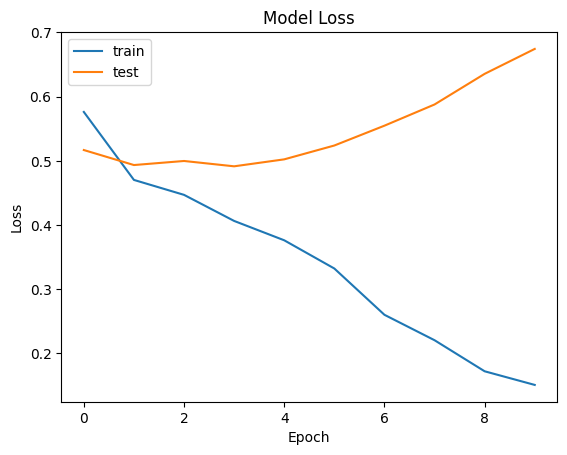

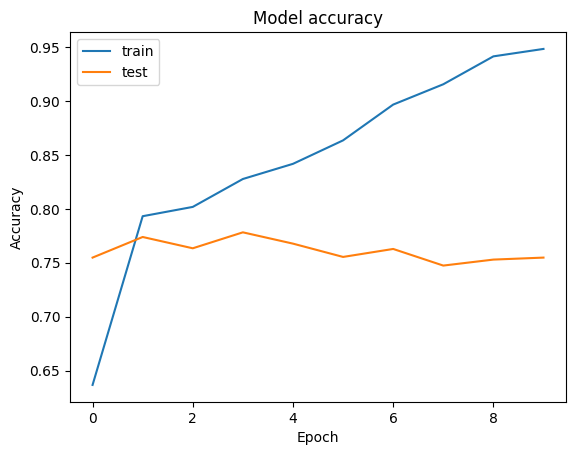

In [71]:
# Plot the loss and validation loss over epochs
plt.plot(binary_model.history['loss'], label='train')
plt.plot(binary_model.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.plot(binary_model.history['accuracy'], label='train')
plt.plot(binary_model.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Using the DenseNet 201 model 

In [28]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up values
epochs = 100
input_shape=(224,224,3)
batch_size=16

# Load the DenseNet201 model
densenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# Build a classifier on top of the DenseNet201 model with additional layers
model = Sequential([
    densenet201,
    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),


    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),


    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),


    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),


    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),


    Flatten(),

    Dense(units=1024),
    Activation('relu'),
    Dense(units=1024),
    Activation('relu'),
    Dense(units=1024),
    Activation('relu'),
    Dense(units=1024),
    Activation('relu'),
    Dense(units=1024),
    Activation('relu'),
    Dense(units=4),
    Activation('softmax')
])

# Compile the model with a lower learning rate
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input, rescale=1./255,
                                   #rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
                                   )
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input,rescale=1./255,
                                  #rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
                                  )

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(224, 224),
batch_size=batch_size,
class_mode='categorical',
subset='training',
classes=['On a budget', 'Moderate spend', 'Special occasion', 'Spare no expense'])

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(224, 224),
batch_size=batch_size,
class_mode='categorical',
subset='training',
classes=['On a budget', 'Moderate spend', 'Special occasion', 'Spare no expense'],
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(224, 224),
batch_size=batch_size,
class_mode='categorical',
classes=['On a budget', 'Moderate spend', 'Special occasion', 'Spare no expense'])

# Train the model and save the history
DenseNet_model = model.fit(train_batch, epochs=epochs, validation_data=test_batch)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Found 602 images belonging to 4 classes.
Epoch 1/100
1108/1108 [==============================] - 217s 180ms/step - loss: 1.3581 - accuracy: 0.2936 - val_loss: 1.6459 - val_accuracy: 0.2744
Epoch 2/100
1108/1108 [==============================] - 197s 178ms/step - loss: 1.3526 - accuracy: 0.3153 - val_loss: 1.3649 - val_accuracy: 0.2956
Epoch 3/100
1108/1108 [==============================] - 189s 171ms/step - loss: 1.3473 - accuracy: 0.3144 - val_loss: 1.5178 - val_accuracy: 0.3293
Epoch 4/100
1108/1108 [==============================] - 189s 170ms/step - loss: 1.3400 - accuracy: 0.3280 - val_loss: 1.4101 - val_accuracy: 0.2879
Epoch 5/100
1108/1108 [==============================] - 197s 178ms/step - loss: 1.3454 - accuracy: 0.3166 - val_loss: 1.3584 - val_accuracy: 0.3260
Epoch 6/100
1108/1108 [==============================] - 198s 178ms/step - loss: 1.3314 - accuracy: 0.3387 - val_loss: 1.3647 - v

KeyboardInterrupt: 

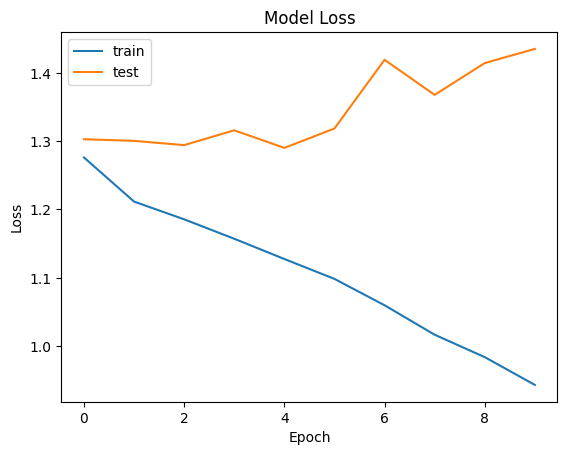

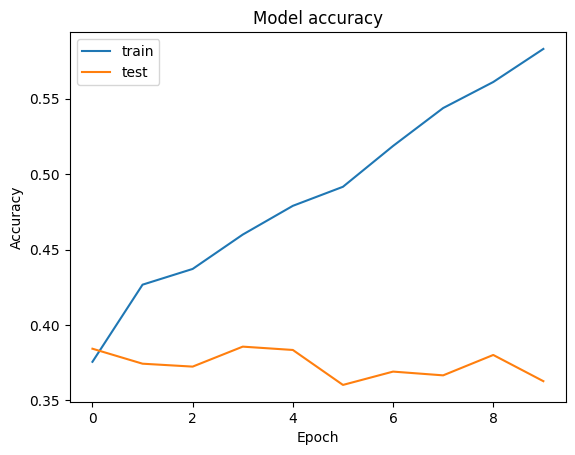

In [19]:
# Plot the loss and validation loss over epochs
plt.plot(DenseNet_model.history['loss'], label='train')
plt.plot(DenseNet_model.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.plot(DenseNet_model.history['accuracy'], label='train')
plt.plot(DenseNet_model.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import *
from tensorflow.keras.applications import ResNet50

# Define the input size
input_shape = (299, 299)

# Define the batch size
batch_size = 32

# Define the paths to your training, validation, and test data
train_dir = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2'
val_dir = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test_2'
test_dir = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\valid_2'


# Define the data generator for training data
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

# Define the data generator for validation data
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Define the data generator for test data
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Define the base model for pretraining
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define the multi-output model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)

output1 = Dense(1, activation='sigmoid', name='On_a_budget')(x)
output2 = Dense(1, activation='sigmoid', name='Moderate_spend')(x)
output3 = Dense(1, activation='sigmoid', name='Special_occasion')(x)
output4 = Dense(1, activation='sigmoid', name='Spare_no_expense')(x)


# Evaluate the model
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.n // batch_size)

print('Test accuracy:', test_acc)


Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Found 602 images belonging to 4 classes.


ValueError: `input_shape` must be a tuple of three integers.

Exporting the model. 

In [10]:
# Save Weight model
model.save_weights("model1.h5")